# Notebook: Regularization with Analysis in Social Network for Recommender Systems

This notebook provides a short view of the implementation of my minipaper "Regularization with Analysis in Social Network for Recommender Systems".

The notebook will use a auto training framework which is completely implemented by myself, whose code lies in `src/`. So in this notebook, I just directly use my framework without showing the details.

Before running the notebook, the following dependencies are required.

- numpy
- numba (Use JIT to speed up training. You can also remove it.)
- matplotlib

The reason that I do not use `scipy.sparse` or `pytorch.sparse` is that their sparse matrices are not suitable for implementing our algorithms, and the speed up is limited. It is difficult to parallelize the calculation of sparse matrices so we just train our model in CPU.

## Initialize the Benchmark

We put all of our three models into the bench mark. The baselines are set internally in the benchmark.

In [21]:
import numpy
import matplotlib
import numba
from matplotlib import pyplot as plt

In [7]:
from benchmark import BenchMark

from Scheduler import *

"""
    BenchMark takes three types of input: dataset, models and other training parameters.
"""

# It is a list, contains all models' configs
model_configs = []

# We take the average of 5 times as our results
# Therefore for each model we repeatedly put it 5 times into the benchmark. 
for i in range(5):
    model_configs.append({
        "model": "MF",
        "lambda1": 0.01,
        "lambda2": 0.01,
        "scheduler": douban_scheduler
    })

    model_configs.append({
        "model": "SR",
        "lambda1": 0.01,
        "lambda2": 0.01,
        "beta": 5,
        "scheduler": douban_scheduler
    })

    model_configs.append({
        "model": "TriSR",
        "lambda1": 0.01,
        "lambda2": 0.01,
        "alpha": 2,
        "beta":  5,
        "gamma": 3,
        "scheduler": douban_scheduler
    })

# We first run the models on the Douban dataset.
douban_benchmark = BenchMark(dataset="douban",
                      learning_rate=0.008,
                      batch_size=256,
                      max_iterations=500,
                      model_configs=model_configs)

[dataloader] dataset douban loaded finish.
[dataloader] === dataset profile ===
Dataset Name: Douban
UserNum=3022, ItemNum=6971, RatingNum=195493
TrainSet Size=117695, TestSet Size=77798

[benchmark] dataset load finish
[benchmark] baselines load finish
[benchmark] models load finish


The dataloader is inlined in the benchmark. We can take a glance of our Douban dataset.

In [9]:
douban_benchmark.dataloader.show_dataset()

[dataloader] === dataset profile ===
Dataset Name: Douban
UserNum=3022, ItemNum=6971, RatingNum=195493
TrainSet Size=117695, TestSet Size=77798



And for TriSR, we can plot the influence distribution. Here we take the third model (which is a TriSR) as an example.

/home/sirius/anaconda3/envs/SR_HOMEWORK/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


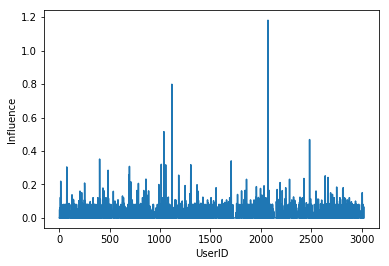

In [5]:
plt.legend()
plt.xlabel("UserID")
plt.ylabel("Influence")
plt.plot(range(1, douban_benchmark.dataloader.userNum+1), douban_benchmark.models[2].rank)
plt.show()

# Training

To show the process of training, we do not directly use `douban_benchmark`. Instead, we create a small test benchmark with only a single TriSR running on it and train it to plot the descent of loss.

For learning, we use a self-implemented Adam Optimizer in the first and switch to Mini-batch SGD after some iterations. For each dataset, we use a unique learning rate scheduler (a basic decay strategy) to achieve the best performance.

In [6]:
# create a new benchmark for testing

test_benchmark = BenchMark(dataset="douban", learning_rate=0.008, batch_size=256, 
                           model_configs=[{
                               "model": "TriSR",
                               "lambda1": 0.01,
                               "lambda2": 0.01,
                               "alpha": 2,
                               "beta":  5,
                               "gamma": 3,
                               "scheduler": douban_scheduler
                           }])

[dataloader] dataset douban loaded finish.
[dataloader] === dataset profile ===
Dataset Name: Douban
UserNum=3022, ItemNum=6971, RatingNum=195493
TrainSet Size=117695, TestSet Size=77798

[benchmark] dataset load finish
[benchmark] baselines load finish
[benchmark] models load finish


In [7]:
# training.

test_benchmark.train(iterations = 500, display_interval = 30, test_interval = 999) # a demo

running on CPU. iterations = 500.
iteration 29, loss = 17.10342135218055, learning rate = 0.007442092031913413
iteration 59, loss = 16.307699499604503, learning rate = 0.005848509517727418
iteration 89, loss = 12.280619702342403, learning rate = 0.004596162400608457
iteration 119, loss = 9.610159767795903, learning rate = 0.003611981608089339
iteration 149, loss = 8.988279723715532, learning rate = 0.0028385444203295604
iteration 179, loss = 8.559741739168606, learning rate = 0.0022307241011800824
iteration 209, loss = 9.32949040916821, learning rate = 0.001753056947055966
iteration 239, loss = 8.20712500024261, learning rate = 0.0013776731322333476
iteration 269, loss = 8.905750086847881, learning rate = 0.001082670624285801
iteration 299, loss = 8.055026688885503, learning rate = 0.0008508372946137014
iteration 329, loss = 8.593582190550794, learning rate = 0.0006686466647075694
iteration 359, loss = 8.119152103006112, learning rate = 0.0005254686942555152
iteration 389, loss = 8.339

/home/sirius/anaconda3/envs/SR_HOMEWORK/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


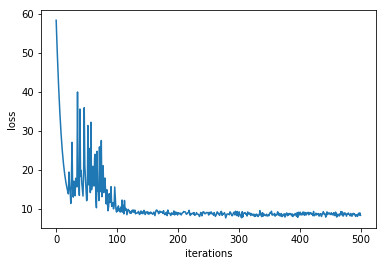

In [8]:
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(500), test_benchmark.models[0].loss_record)
plt.show()

/home/sirius/anaconda3/envs/SR_HOMEWORK/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


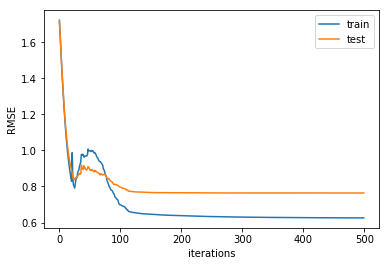

In [10]:
plt.legend()
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.plot(range(500), test_benchmark.models[0].RMSE_train_record)
plt.plot(range(500), test_benchmark.models[0].RMSE_test_record)
plt.legend(['train','test'])
plt.show()

And then we start to systematically judge our models.

In [10]:
douban_benchmark.train(display_interval = 9999, test_interval = 9999)

result_dict_MAE, result_dict_RMSE = douban_benchmark.average_dump()

print("")
print("=== MAE ===")
for key in result_dict_MAE:
    print("{}: {}".format(key, result_dict_MAE[key]))

print("")
print("=== RMSE ===")
for key in result_dict_RMSE:
    print("{}: {}".format(key, result_dict_RMSE[key]))

running on CPU. iterations = 500.
Model 0 [Simple MF] trained finish.
Model 1 [SR] trained finish.
Model 2 [TriSR] trained finish.
Model 3 [Simple MF] trained finish.
Model 4 [SR] trained finish.
Model 5 [TriSR] trained finish.
Model 6 [Simple MF] trained finish.
Model 7 [SR] trained finish.
Model 8 [TriSR] trained finish.
Model 9 [Simple MF] trained finish.
Model 10 [SR] trained finish.
Model 11 [TriSR] trained finish.
Model 12 [Simple MF] trained finish.
Model 13 [SR] trained finish.
Model 14 [TriSR] trained finish.
[benchmark] average dump.

=== MAE ===
UserMean: 0.6960723507772897
ItemMean: 0.6265491721572017
UserCF: 0.6873764008003617
ItemCF: 0.7461927278973325
MF: 0.5984036467118651
SR: 0.5972992910591406
TriSR: 0.595948748674831

=== RMSE ===
UserMean: 0.86749016087495
ItemMean: 0.7875021673837718
UserCF: 0.874305487286352
ItemCF: 0.9440067752841698
MF: 0.7625748260351093
SR: 0.7613964427052318
TriSR: 0.7597055713869345


## Impact of Parameters

Compare different $\alpha$, $\beta$ and $\gamma$.

In [26]:
para_models = []

# 3 times average
for i in range(3):
    for n in range(-2, 3):
        alpha = 2 * (10**n)
        # print("alpha = ", alpha)
        para_models.append({
            "model": "TriSR",
            "lambda1": 0.01,
            "lambda2": 0.01,
            "alpha": alpha,
            "beta":  5,
            "gamma": 3,
            "scheduler": douban_scheduler
        })

para_benchmark = BenchMark(dataset="douban", learning_rate=0.006, batch_size=256, model_configs=para_models)

[dataloader] dataset douban loaded finish.
[dataloader] === dataset profile ===
Dataset Name: Douban
UserNum=3022, ItemNum=6971, RatingNum=195493
TrainSet Size=117695, TestSet Size=77798

[benchmark] dataset load finish
[benchmark] baselines load finish
[benchmark] models load finish


In [28]:
para_benchmark.train(500, 9999, 9999)

running on CPU. iterations = 500.
Model 0 [TriSR] trained finish.
Model 1 [TriSR] trained finish.
Model 2 [TriSR] trained finish.
Model 3 [TriSR] trained finish.
Model 4 [TriSR] trained finish.
Model 5 [TriSR] trained finish.
Model 6 [TriSR] trained finish.
Model 7 [TriSR] trained finish.
Model 8 [TriSR] trained finish.
Model 9 [TriSR] trained finish.
Model 10 [TriSR] trained finish.
Model 11 [TriSR] trained finish.
Model 12 [TriSR] trained finish.
Model 13 [TriSR] trained finish.
Model 14 [TriSR] trained finish.


/home/sirius/anaconda3/envs/SR_HOMEWORK/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


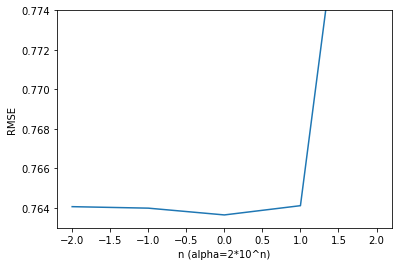

In [40]:
data = numpy.zeros(5)

for i in range(3):
    for j in range(5):
        data[j] += para_benchmark.models[i*5+j].RMSE

data /= 3

plt.ylim((0.763,0.774))
plt.legend()
plt.xlabel('n (alpha=2*10^n)')
plt.ylabel('RMSE')
plt.plot([-2, -1, 0, 1, 2], data)
plt.show()

In [41]:
para_models = []

# 3 times average
for i in range(3):
    for n in range(-2, 3):
        gamma = 5 * (10**n)
        para_models.append({
            "model": "TriSR",
            "lambda1": 0.01,
            "lambda2": 0.01,
            "alpha": 2,
            "beta":  5,
            "gamma": gamma,
            "scheduler": douban_scheduler
        })

para_benchmark = BenchMark(dataset="douban", learning_rate=0.006, batch_size=256, model_configs=para_models)

[dataloader] dataset douban loaded finish.
[dataloader] === dataset profile ===
Dataset Name: Douban
UserNum=3022, ItemNum=6971, RatingNum=195493
TrainSet Size=117695, TestSet Size=77798

[benchmark] dataset load finish
[benchmark] baselines load finish
[benchmark] models load finish


In [43]:
para_benchmark.train(500, 9999, 9999)

running on CPU. iterations = 500.
Model 0 [TriSR] trained finish.
Model 1 [TriSR] trained finish.
Model 2 [TriSR] trained finish.
Model 3 [TriSR] trained finish.
Model 4 [TriSR] trained finish.
Model 5 [TriSR] trained finish.
Model 6 [TriSR] trained finish.
Model 7 [TriSR] trained finish.
Model 8 [TriSR] trained finish.
Model 9 [TriSR] trained finish.
Model 10 [TriSR] trained finish.
Model 11 [TriSR] trained finish.
Model 12 [TriSR] trained finish.
Model 13 [TriSR] trained finish.
Model 14 [TriSR] trained finish.


/home/sirius/anaconda3/envs/SR_HOMEWORK/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


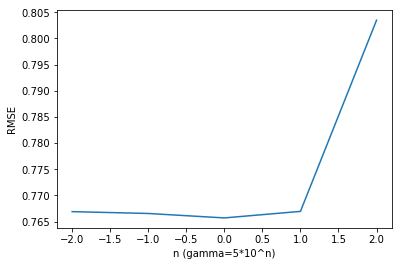

In [44]:
data = numpy.zeros(5)

for i in range(3):
    for j in range(5):
        data[j] += para_benchmark.models[i*5+j].RMSE

data /= 3

plt.legend()
plt.xlabel('n (gamma=5*10^n)')
plt.ylabel('RMSE')
plt.plot([-2, -1, 0, 1, 2], data)
plt.show()

## Other Datasets

We also need to test our models on Dianping and Epinions, which are both larger than Douban. The process is similar only with some differences in parameter setting. 

### Dianping

In [ ]:
model_configs = []

for i in range(5):
    model_configs.append({
        "model": "MF",
        "lambda1": 0.01,
        "lambda2": 0.01,
        "scheduler": dianping_scheduler
    })

    model_configs.append({
        "model": "SR",
        "lambda1": 0.01,
        "lambda2": 0.01,
        "beta": 5,
        "scheduler": dianping_scheduler
    })

    model_configs.append({
        "model": "TriSR",
        "lambda1": 0.01,
        "lambda2": 0.01,
        "alpha": 2,
        "beta":  5,
        "gamma": 3,
        "scheduler": dianping_scheduler
    })

dianping_benchmark = BenchMark(dataset="dianping",
                      learning_rate=0.001,
                      batch_size=8192,
                      max_iterations=1500,
                      feature_dim = 20,
                      model_configs=model_configs)

dianping_benchmark.train(display_interval = 9999, test_interval = 9999)

result_dict_MAE, result_dict_RMSE = dianping_benchmark.average_dump()

print("")
print("=== MAE ===")
for key in result_dict_MAE:
    print("{}: {}", key, result_dict_MAE[key])

print("")
print("=== RMSE ===")
for key in result_dict_RMSE:
    print("{}: {}", key, result_dict_RMSE[key])

### Epinions

In [ ]:
model_configs = []

for i in range(5):
    model_configs.append({
        "model": "MF",
        "lambda1": 0.00001,
        "lambda2": 0.00001,
        "scheduler": epinions_scheduler
    })

    model_configs.append({
        "model": "SR",
        "lambda1": 0.00001,
        "lambda2": 0.00001,
        "beta": 0.55,
        "scheduler": epinions_scheduler
    })

    model_configs.append({
        "model": "TriSR",
        "lambda1": 0.00001,
        "lambda2": 0.00001,
        "alpha": 0.25,
        "beta":  0.5,
        "gamma": 0.25,
        "scheduler": epinions_scheduler
    })

epinions_benchmark = BenchMark(dataset="epinions",
                      learning_rate=0.001,
                      batch_size=2048,
                      feature_dim = 20,
                      max_iterations=1500,
                      model_configs=model_configs)

epinions_benchmark.train(display_interval = 9999, test_interval = 9999)

result_dict_MAE, result_dict_RMSE = epinions_benchmark.average_dump()

print("")
print("=== MAE ===")
for key in result_dict_MAE:
    print("{}: {}", key, result_dict_MAE[key])

print("")
print("=== RMSE ===")
for key in result_dict_RMSE:
    print("{}: {}", key, result_dict_RMSE[key])